# Group Members:

 Name 1 : **Leticia Martín Cabrera - 230781**
 
  Name 2 : **Júlia Ruiz Valero - 230308**

# Lab 3 Assignment (Our images)

#### **4. Take a picture of two different faces (u1 and u2) and apply Poisson editing (it will be better if the faces are from the two components of the group). Try using u1 as a background and the face of u2 and the way around. Notice that you will need to create your own mask.**

**Goal of the practical session**:

<font color="blue"> In this part of the practical session we will apply the Poisson editing to our pictures. </font>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/LAB3_optimization/jupyter"

/content/drive/MyDrive/LAB3_optimization/jupyter


In [3]:
# Install if required
# !python -m pip install opencv-python

In [4]:
import numpy as np
from PIL import Image 
import os
import cv2 as cv
import matplotlib.pyplot as plt
from math import sqrt
from IPython.display import clear_output, display

<font color="blue"> We will do two experiments. In the first one we will take Leticia's face as the mask and Júlia's as a background, and in the second experiment we will do it in the other way round.  </font>

**FIRST EXPERIMENT**

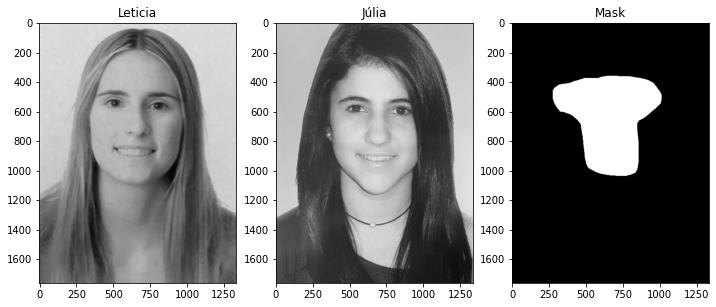

In [5]:
# Define the images directory
images_dir = os.path.abspath("../images")

# Read all the required images
leti = Image.open(os.path.join(images_dir, "leti.JPG"))
juls = Image.open(os.path.join(images_dir, "juls.jpg"))
mask_leti = Image.open(os.path.join(images_dir, "mask_leti.jpg"))

# Convert all the images to 2D
u1 = np.array(leti, dtype = float)[:, :, 0]
u2 = np.array(juls, dtype = float)[:, :, 0]
mask = np.array(mask_leti, dtype = float) [:, :, 0] / 255

# Show all the images
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 8))
ax1.imshow(u1, cmap = "gray")
ax1.set_title("Leticia")
ax2.imshow(u2, cmap = "gray")
ax2.set_title("Júlia")
ax3.imshow(mask, cmap = "gray")
ax3.set_title("Mask")
plt.show()

**Apply filters to images**

Learn more about Gaussian blurring [here](https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html)

In [6]:
u1 = cv.GaussianBlur(src = u1, ksize = (9, 9), sigmaX = 2, borderType = cv.BORDER_REFLECT)
u2 = cv.GaussianBlur(src = u2, ksize = (11, 11), sigmaX = 4, borderType = cv.BORDER_REFLECT)

**Crude composition**

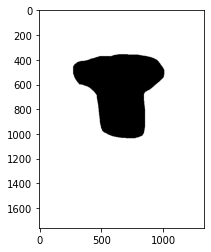

In [7]:
plt.imshow ((1-mask), cmap= "gray")

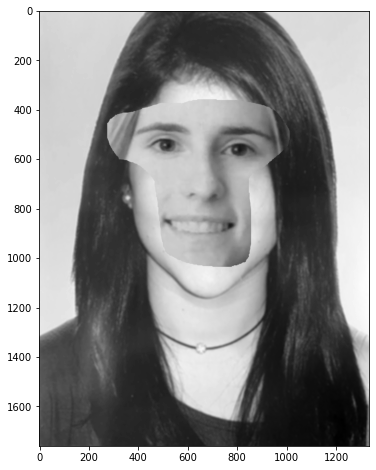

In [8]:
# TODO: generate an image which is u1 when mask = 1, and u2 when mask = 0
ucomp = mask*u1 + (1-mask)*u2

# Show the composed image
plt.figure(figsize = (12, 8))
plt.imshow(ucomp, cmap = "gray")

**Guiding vector field**

We compose the images, but at the gradient level!

In [9]:
def im_fwd_gradient(image: np.matrix):
    """
    Discrete gradient of an image using forward differences, with homogeneous Neuman boundary conditions.

    :param u: image (MxN)
            
    :return gradu_j: partial derivative in the j (rows) direction (also x direction)
    :return gradu_i: partial derivative in the i (cols) direction (also y direction)
    """
    # Get the size of the image
    image_shape = image.shape
    
    # Calculate both gradients
    gradu_j = np.append(np.diff(image, axis = 1), np.zeros((image_shape[0], 1)), axis = 1)
    gradu_i = np.append(np.diff(image, axis = 0), np.zeros((1, image_shape[1])), axis = 0)
    return gradu_i, gradu_j

In [10]:
# TODO: Compute the gradients of u1 and u2, and define a new gradient [vj,vi] 
#       which corresponds to the gradient of u1 when mask = 1, and the gradient 
#       of u2 when mask = 0

# Compute the gradient of the images
gu1i, gu1j = im_fwd_gradient (u1)
gu2i, gu2j = im_fwd_gradient (u2)
# Calculate v
vi = mask*gu1i + (1-mask)*gu2i
vj = mask*gu1j + (1-mask)*gu2j

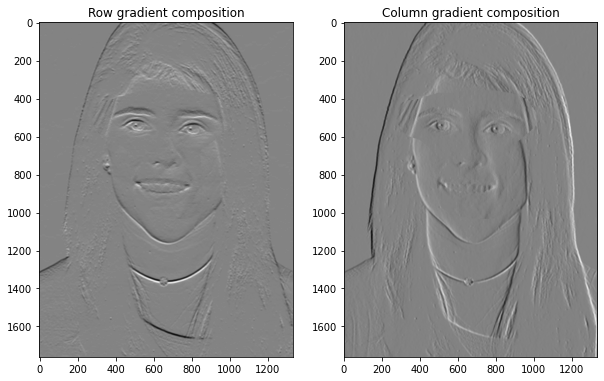

In [11]:
#show gradient composition
fig, (ax1, ax2) = plt.subplots (nrows = 1, ncols = 2, figsize = (10,8))
ax1.imshow (vi, cmap = "gray")
ax1.set_title ("Row gradient composition")
ax2.imshow (vj, cmap = "gray")
ax2.set_title ("Column gradient composition")
plt.show()

**Conjugate gradient set up**

In [15]:
def im_bwd_divergence(gradient_i: np.matrix,
                      gradient_j: np.matrix):
    """
    Discrete divergence of a vector field using backwards differences. 
    This is the negative transpose of the im_fwd_gradient
    
    :param gradient_i: component of g in the direction j (rows) (also x direction)
    :param gradient_j: component of g in the direction i (cols) (also y direction)
    
    :return divg: backwards divergence of g
    """
    # Backwards j partial derivative of gradient_j
    gradient_j[:, gradient_j.shape[1] - 1] = 0
    divg = np.diff(np.append(np.zeros((gradient_j.shape[0], 1)), gradient_j, axis = 1), axis = 1)
    
    # Backwards i partial derivative of gradient_i
    gradient_i[gradient_i.shape[0] - 1, :] = 0
    divg = np.diff(np.append(np.zeros((1, gradient_i.shape[1])), gradient_i, axis = 0), axis = 0) + divg
    
    return divg

In [16]:
def poisson_linear_operator(u, beta):
    """
    Discrete laplacian of an image using a forward gradient and 
    a backward divergence. It computes the Laplacian inside a region indicated by a 
    mask (mask = 1). It assumes u(x) = 0 for x outside the mask (homogeneous
    Dirichlet boundary conditions). The interface is compatible with
    conjugate_gradient and gradient_descent.

    lap = im_laplacian_mask(u,prms)

    param u: image (MxN)
    param prms: structure with one field, prms.mask, a (MxN) binary image

    :return lap: laplacian
    """
    gu_i , gu_j = im_fwd_gradient(u)
    lapu = (-1) * im_bwd_divergence(gu_i, gu_j)
    return lapu + beta * u

In [17]:
def conjugate_gradient(callback,
                       b: np.matrix,
                       callback_params: dict,
                       initial_condition: np.matrix,
                       tolerance: float,
                       max_iters: int,
                       fig = None,
                       ax = None):
    """
    implementation of the conjugate gradient algorithm for the minimization of quadratic problems 

       f(x) = 1/2 x'Ax - bx. 

    It uses function handles. It requires a handle to a Python function that implements the product of matrix A with x.

    :param callback: handle (pointer) to a matlab function implementing the product with matrix A. 
    :param callback_params: dictionary containing the params for the callback functions
    :param b: vector b, can be in matrix form (MxN)
    :param initial_conditions: initial condition, same dimensions as b (MxN)
    :param max_iters: maximum number of iterations
    :param tolerance: tolerance for the stopping condition (it stop when the norm of the gradient is below the tolerance)

    :return x: value found (MxN)
    :return fs: evolution of the target function (total_iters x 1 vector)
    """

  

    Ax = callback(initial_condition, **callback_params)
    r = Ax-b                        # TODO: compute residual (the gradient)
    nr = np.multiply (r,r).sum()    # TODO: inner product of gradient
    d = -r.copy()                   # TODO: first descent direction is the negative grad.
    
    # Note: since the variables can be stored as matrices (for example, x is an image)
    #       we use np.multiply(x1, x2) to compute the dot products.

    # Allocate memory for vector of energy values of the iterates
    fs  = []
    current_value = initial_condition

    # Start loop 
    it = 0

    while (sqrt(nr) > tolerance) and (it < max_iters):
        # Increase iteration counter
        it = it + 1
        if it % 10 == 0:
            print("[{} of {}]\t-> |grad f(x)| = {}".format(it, max_iters, nr))

        # Compute quadratic energy f = .5 <Ax - b,x> - 0.5* <b,x>
        fs.append(0.5 * np.multiply(r, current_value).sum() - 0.5 * np.multiply(b, current_value).sum())

        # 1. TODO: line search in d - compute time step alpha
        Ad = callback(d, **callback_params)
        alpha = np.multiply (d,r).sum()/np.multiply(d,Ad).sum()

        previous_value = current_value # keep x_old - just for visualization

        #2. TODO: update point x
        current_value = current_value -alpha * d 

        # compute new residual r = Ax - b
        Ax = callback(current_value, **callback_params)
        r = Ax-b                          # TODO: compute residual (the gradient)
        nr_old = nr                       # inner product of the old residual
        nr = np.multiply (r,r).sum()      # TODO: squared norm of gradient

        # A-orthogonalization of r (Gram-Schmidt)
        # new search direction d is a linear combination of r and previous d
        # chosen so that it is A-orthogonal with the previous search directions
        beta_2 = nr/nr_old
        d = (-1)*r + beta_2*d
        
        # ----- plot current position! Just for visualization purposes -----
        if current_value.shape == (2, 1):
            if not ax:
                fig, ax = plt.subplots()
            ax.plot(current_value[0, 0], current_value[1, 0], marker = 'o', color = "r")
            ax.plot([previous_value[0, 0], current_value[0, 0]], 
                    [previous_value[1, 0], current_value[1, 0]], "-r")
            clear_output(wait=True)
            display(fig) 
        elif current_value.shape[0] > 1 and current_value.shape[1] > 1:
            # if x is a matrix (an image) (visualization of denoising) 
            if it % 10 == 0:
                if not ax:
                    fig, ax = plt.subplots(figsize = (12, 8))
                ax.imshow(current_value, cmap = "gray")
                clear_output(wait=True)
                display(fig) 
                
    print("[{} of {}]\t-> |grad f(x)| = {}".format(it, max_iters, nr))
    return current_value, np.matrix(fs).T

<font color="blue"> Now we will apply the juls_leti_test to our images: </font>

In [18]:
def juls_leti_test(u1: np.matrix, 
                      u2: np.matrix,
                      mask: np.matrix):
    # TODO: CRUDE COMPOSITION
    ucomp = u1*mask +u2*(1-mask)
    # TODO: GUIDING VECTOR FIELD
    gu1i, gu1j = im_fwd_gradient(u1)
    gu2i, gu2j = im_fwd_gradient(u2)
    #Calculate v
    vi= gu1i * mask + gu2i * (1-mask)
    vj= gu1j * mask + gu2i * (1-mask)
    
    # Define beta_0 and calculate beta
    beta_0 = 20                            # TRY CHANGING
    beta = beta_0 * (1 - mask)

    # Calculate the right hand term with bounday data
    b = (-1) * im_bwd_divergence(vi, vj) + beta * u2

    # Define the parameters to be used when calculating the conjugate gradient
    initial_condition = np.zeros_like(u1)  # TRY CHANGING    
    tolerance = 1                          # TRY CHANGING #baja tolerance, tarda mes en convergir mes exacte
    max_iters = 1000                       # TRY CHANGING
    upns, fs = conjugate_gradient(callback = poisson_linear_operator,
                                  b = b,
                                  callback_params = {"beta": beta},
                                  initial_condition = initial_condition,
                                  tolerance = tolerance,
                                  max_iters = max_iters)
    
    # Plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 8))
    ax1.imshow(u1, cmap = "gray")
    ax1.set_title("Leticia")
    ax2.imshow(u2, cmap = "gray")
    ax2.set_title("Júlia")
    ax3.imshow(upns, cmap = "gray")
    ax3.set_title("composing gradients")
    ax4.imshow(ucomp, cmap = "gray")
    ax4.set_title("composing gray levels")
    plt.show()

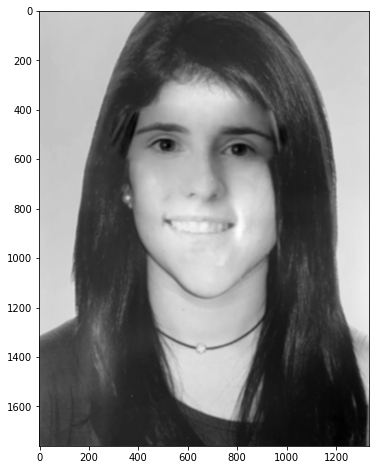

[1000 of 1000]	-> |grad f(x)| = 238.93391455593732


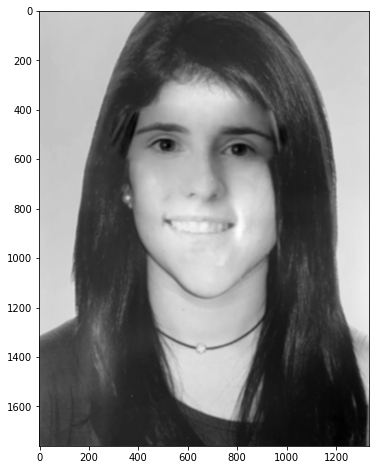

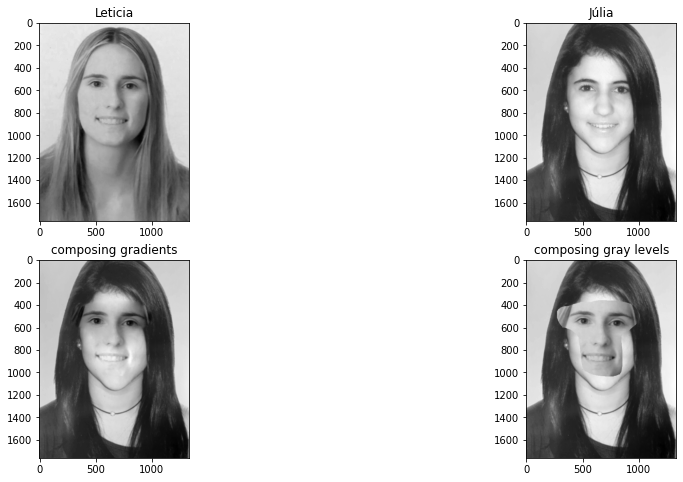

In [19]:
juls_leti_test (u1, u2, mask)

**SECOND EXPERIMENT**

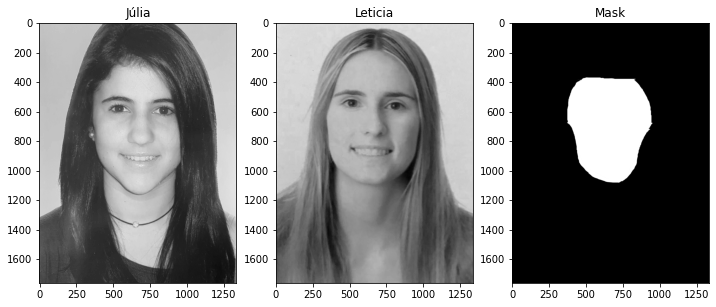

In [20]:
# Define the images directory
images_dir = os.path.abspath("../images")

# Read all the required images
leti = Image.open(os.path.join(images_dir, "leti.JPG"))
juls = Image.open(os.path.join(images_dir, "juls.jpg"))
mask_juls = Image.open(os.path.join(images_dir, "mask_juls.jpg"))

# Convert all the images to 2D
u1 = np.array(juls, dtype = float)[:, :, 0]
u2 = np.array(leti, dtype = float)[:, :, 0]
mask = np.array(mask_juls, dtype = float) [:, :, 0] / 255

# Show all the images
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 8))
ax1.imshow(u1, cmap = "gray")
ax1.set_title("Júlia")
ax2.imshow(u2, cmap = "gray")
ax2.set_title("Leticia")
ax3.imshow(mask, cmap = "gray")
ax3.set_title("Mask")
plt.show()

**Apply filters to images**

Learn more about Gaussian blurring [here](https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html)

In [21]:
u1 = cv.GaussianBlur(src = u1, ksize = (9, 9), sigmaX = 2, borderType = cv.BORDER_REFLECT)
u2 = cv.GaussianBlur(src = u2, ksize = (11, 11), sigmaX = 4, borderType = cv.BORDER_REFLECT)

**Crude composition**

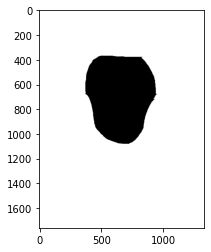

In [22]:
plt.imshow ((1-mask), cmap= "gray")

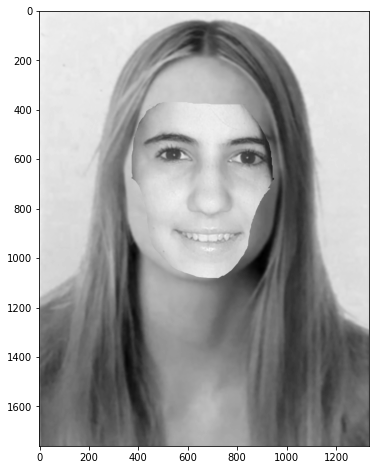

In [23]:
# TODO: generate an image which is u1 when mask = 1, and u2 when mask = 0
ucomp = mask*u1 + (1-mask)*u2

# Show the composed image
plt.figure(figsize = (12, 8))
plt.imshow(ucomp, cmap = "gray")

**Guiding vector field**

We compose the images, but at the gradient level!

In [24]:
def im_fwd_gradient(image: np.matrix):
    """
    Discrete gradient of an image using forward differences, with homogeneous Neuman boundary conditions.

    :param u: image (MxN)
            
    :return gradu_j: partial derivative in the j (rows) direction (also x direction)
    :return gradu_i: partial derivative in the i (cols) direction (also y direction)
    """
    # Get the size of the image
    image_shape = image.shape
    
    # Calculate both gradients
    gradu_j = np.append(np.diff(image, axis = 1), np.zeros((image_shape[0], 1)), axis = 1)
    gradu_i = np.append(np.diff(image, axis = 0), np.zeros((1, image_shape[1])), axis = 0)
    return gradu_i, gradu_j

In [25]:
# TODO: Compute the gradients of u1 and u2, and define a new gradient [vj,vi] 
#       which corresponds to the gradient of u1 when mask = 1, and the gradient 
#       of u2 when mask = 0

# Compute the gradient of the images
gu1i, gu1j = im_fwd_gradient (u1)
gu2i, gu2j = im_fwd_gradient (u2)
# Calculate v
vi = mask*gu1i + (1-mask)*gu2i
vj = mask*gu1j + (1-mask)*gu2j

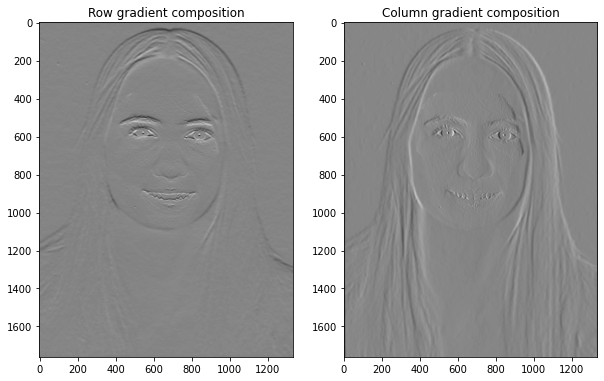

In [26]:
#show gradient composition
fig, (ax1, ax2) = plt.subplots (nrows = 1, ncols = 2, figsize = (10,8))
ax1.imshow (vi, cmap = "gray")
ax1.set_title ("Row gradient composition")
ax2.imshow (vj, cmap = "gray")
ax2.set_title ("Column gradient composition")
plt.show()

**Conjugate gradient set up**

In [27]:
def im_bwd_divergence(gradient_i: np.matrix,
                      gradient_j: np.matrix):
    """
    Discrete divergence of a vector field using backwards differences. 
    This is the negative transpose of the im_fwd_gradient
    
    :param gradient_i: component of g in the direction j (rows) (also x direction)
    :param gradient_j: component of g in the direction i (cols) (also y direction)
    
    :return divg: backwards divergence of g
    """
    # Backwards j partial derivative of gradient_j
    gradient_j[:, gradient_j.shape[1] - 1] = 0
    divg = np.diff(np.append(np.zeros((gradient_j.shape[0], 1)), gradient_j, axis = 1), axis = 1)
    
    # Backwards i partial derivative of gradient_i
    gradient_i[gradient_i.shape[0] - 1, :] = 0
    divg = np.diff(np.append(np.zeros((1, gradient_i.shape[1])), gradient_i, axis = 0), axis = 0) + divg
    
    return divg

In [28]:
def poisson_linear_operator(u, beta):
    """
    Discrete laplacian of an image using a forward gradient and 
    a backward divergence. It computes the Laplacian inside a region indicated by a 
    mask (mask = 1). It assumes u(x) = 0 for x outside the mask (homogeneous
    Dirichlet boundary conditions). The interface is compatible with
    conjugate_gradient and gradient_descent.

    lap = im_laplacian_mask(u,prms)

    param u: image (MxN)
    param prms: structure with one field, prms.mask, a (MxN) binary image

    :return lap: laplacian
    """
    gu_i , gu_j = im_fwd_gradient(u)
    lapu = (-1) * im_bwd_divergence(gu_i, gu_j)
    return lapu + beta * u

In [29]:
def conjugate_gradient(callback,
                       b: np.matrix,
                       callback_params: dict,
                       initial_condition: np.matrix,
                       tolerance: float,
                       max_iters: int,
                       fig = None,
                       ax = None):
    """
    implementation of the conjugate gradient algorithm for the minimization of quadratic problems 

       f(x) = 1/2 x'Ax - bx. 

    It uses function handles. It requires a handle to a Python function that implements the product of matrix A with x.

    :param callback: handle (pointer) to a matlab function implementing the product with matrix A. 
    :param callback_params: dictionary containing the params for the callback functions
    :param b: vector b, can be in matrix form (MxN)
    :param initial_conditions: initial condition, same dimensions as b (MxN)
    :param max_iters: maximum number of iterations
    :param tolerance: tolerance for the stopping condition (it stop when the norm of the gradient is below the tolerance)

    :return x: value found (MxN)
    :return fs: evolution of the target function (total_iters x 1 vector)
    """

  
    
    Ax = callback(initial_condition, **callback_params)
    r = Ax-b                        # TODO: compute residual (the gradient)
    nr = np.multiply (r,r).sum()    # TODO: inner product of gradient
    d = -r.copy()                   # TODO: first descent direction is the negative grad.
    
    # Note: since the variables can be stored as matrices (for example, x is an image)
    #       we use np.multiply(x1, x2) to compute the dot products.

    # Allocate memory for vector of energy values of the iterates
    fs  = []
    current_value = initial_condition

    # Start loop 
    it = 0

    while (sqrt(nr) > tolerance) and (it < max_iters):
        # Increase iteration counter
        it = it + 1
        if it % 10 == 0:
            print("[{} of {}]\t-> |grad f(x)| = {}".format(it, max_iters, nr))

        # Compute quadratic energy f = .5 <Ax - b,x> - 0.5* <b,x>
        fs.append(0.5 * np.multiply(r, current_value).sum() - 0.5 * np.multiply(b, current_value).sum())

        # 1. TODO: line search in d - compute time step alpha
        Ad = callback(d, **callback_params)
        alpha = np.multiply (d,r).sum()/np.multiply(d,Ad).sum()

        previous_value = current_value # keep x_old - just for visualization

        #2. TODO: update point x
        current_value = current_value -alpha * d 

        # compute new residual r = Ax - b
        Ax = callback(current_value, **callback_params)
        r = Ax-b                          # TODO: compute residual (the gradient)
        nr_old = nr                       # inner product of the old residual
        nr = np.multiply (r,r).sum()      # TODO: squared norm of gradient

        # A-orthogonalization of r (Gram-Schmidt)
        # new search direction d is a linear combination of r and previous d
        # chosen so that it is A-orthogonal with the previous search directions
        beta_2 = nr/nr_old
        d = (-1)*r + beta_2*d
        
        # ----- plot current position! Just for visualization purposes -----
        if current_value.shape == (2, 1):
            if not ax:
                fig, ax = plt.subplots()
            ax.plot(current_value[0, 0], current_value[1, 0], marker = 'o', color = "r")
            ax.plot([previous_value[0, 0], current_value[0, 0]], 
                    [previous_value[1, 0], current_value[1, 0]], "-r")
            clear_output(wait=True)
            display(fig) 
        elif current_value.shape[0] > 1 and current_value.shape[1] > 1:
            # if x is a matrix (an image) (visualization of denoising) 
            if it % 10 == 0:
                if not ax:
                    fig, ax = plt.subplots(figsize = (12, 8))
                ax.imshow(current_value, cmap = "gray")
                clear_output(wait=True)
                display(fig) 
                
    print("[{} of {}]\t-> |grad f(x)| = {}".format(it, max_iters, nr))
    return current_value, np.matrix(fs).T

<font color="blue"> Now, we will apply the leti_juls_test:

In [30]:
def leti_juls_test(u1: np.matrix, 
                      u2: np.matrix,
                      mask: np.matrix):
   
    # TODO: CRUDE COMPOSITION
    ucomp = u1*mask +u2*(1-mask)
    # TODO: GUIDING VECTOR FIELD
    gu1i, gu1j = im_fwd_gradient(u1)
    gu2i, gu2j = im_fwd_gradient(u2)
    #Calculate v
    vi= gu1i * mask + gu2i * (1-mask)
    vj= gu1j * mask + gu2i * (1-mask)
    
    # Define beta_0 and calculate beta
    beta_0 = 20                            
    beta = beta_0 * (1 - mask)

    # Calculate the right hand term with bounday data
    b = (-1) * im_bwd_divergence(vi, vj) + beta * u2

    # Define the parameters to be used when calculating the conjugate gradient
    initial_condition = np.zeros_like(u1)      
    tolerance = 10                          
    max_iters = 1000                        
    upns, fs = conjugate_gradient(callback = poisson_linear_operator,
                                  b = b,
                                  callback_params = {"beta": beta},
                                  initial_condition = initial_condition,
                                  tolerance = tolerance,
                                  max_iters = max_iters)
    
    # Plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 8))
    ax1.imshow(u1, cmap = "gray")
    ax1.set_title("Júlia")
    ax2.imshow(u2, cmap = "gray")
    ax2.set_title("Leticia")
    ax3.imshow(upns, cmap = "gray")
    ax3.set_title("composing gradients")
    ax4.imshow(ucomp, cmap = "gray")
    ax4.set_title("composing gray levels")
    plt.show()

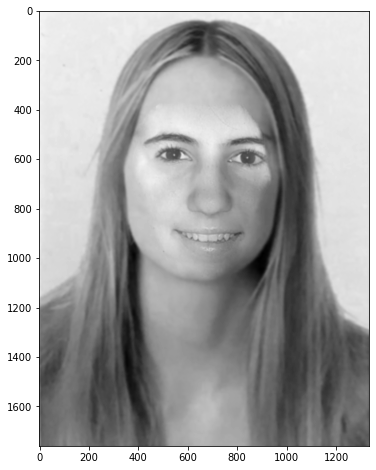

[1000 of 1000]	-> |grad f(x)| = 460.49612431461713


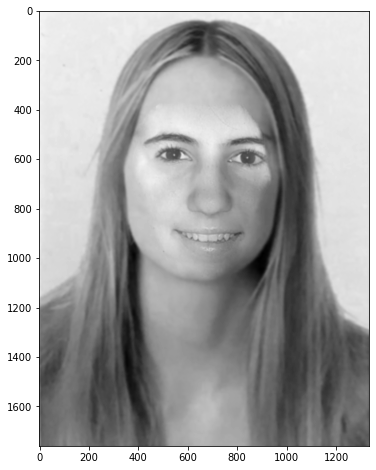

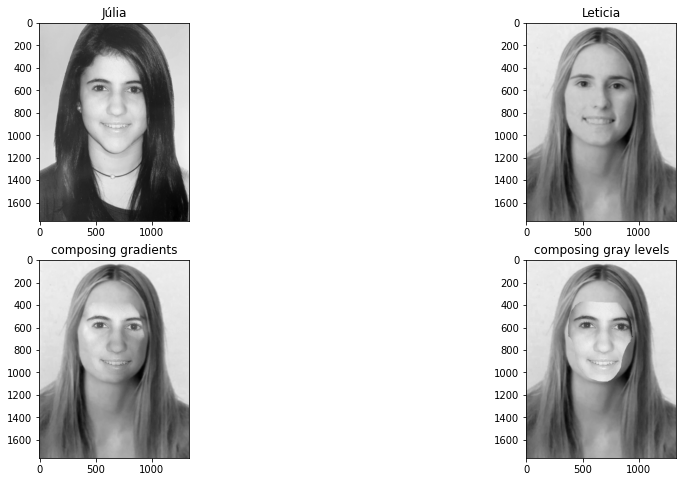

In [32]:
leti_juls_test(u1, u2, mask)

<font color="blue"> Four our images, as mentioned in the second part of the lab, we can also see that when applying composing gradients, we are able to see the the mask in an smoother way than when applying composing gray levels.